In [161]:
from pathlib import Path
import numpy as np
import pandas as pd
import json
from collections import Counter


import imblearn

from time import time
from datetime import datetime, date

import string
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

# define Path object for data directory
root_dir = Path('./')
data_dir = root_dir / 'data'
models_dir = root_dir / 'models'
plots_dir = root_dir / 'plots'

# print data files
for data_file in data_dir.glob('*'):
    print(data_file)
    
# create directory for plots and models
plots_dir.mkdir(exist_ok=True)
models_dir.mkdir(exist_ok=True)

train = pd.read_csv(data_dir / 'train_cleaned.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv(data_dir / 'test_cleaned.csv')

print(train.shape)
train.head(5)

data/train.json
data/test_cleaned.csv
data/train_cleaned.csv
data/test.json
data/twitter_train.csv
(8263, 2)


,text,sentiment
0,досудебн расследован факт покупк енпф пакет об...,0
1,медик рассказа состоян пострада мужчин котор с...,0
2,прошел год железнодорожн оператор запрет экспл...,0
3,итог месяц год территор республик выпущ еди...,0
4,аста ноябр kazakhstan today агентств рк дел ...,0


Average document: 436 words
Longest document: 40554 words
Max required words: 500 words


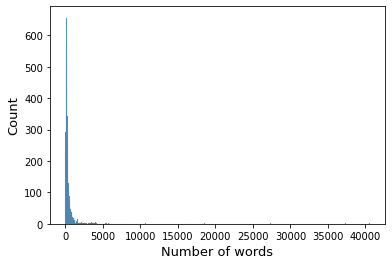

In [162]:
# get the number of words in each sample
doc_len = train.text.apply(lambda doc: len(doc.split(' '))).to_numpy()
max_words = 500

# plot histogram
sns.histplot(doc_len)
plt.xlabel("Number of words", fontsize=13)
plt.ylabel("Count", fontsize=13)

print(f"Average document: {int(doc_len.mean())} words")
print(f"Longest document: {doc_len.max()} words")
print(f"Max required words: {max_words} words")

Number of training examples: 6624
Number of test examples: 1664
Proportion of training examples: 80.16%
Proportion of test examples: 80.93%


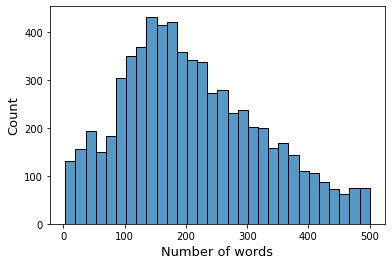

In [163]:
# removing any documents with len(words) >= 500
train500 = train[train.text.apply(lambda x: len(x.split(' '))) <= max_words]
test500 = test[test.text.apply(lambda x: len(x.split(' '))) <= max_words]

sns.histplot(train500.text.apply(lambda x: len(x.split(' '))))
plt.xlabel("Number of words", fontsize=13)
plt.ylabel("Count", fontsize=13)

print(f"Number of training examples: {train500.shape[0]}")
print(f"Number of test examples: {test500.shape[0]}")

print(f"Proportion of training examples: {100*train500.shape[0] / train.shape[0]:.2f}%")
print(f"Proportion of test examples: {100*test500.shape[0] / test.shape[0]:.2f}%")

In [166]:
vocab_count = Counter()

train500.text.str.split().apply(vocab_count.update)

vocab_count = dict(vocab_count)

print(f"Number of distinct words: {len(vocab_count)}")

#sns.histplot(vocab_count.values())

Number of distinct words: 37420


In [167]:
embedded_dim = 30
max_seq_length = max_words

In [168]:
X_train = train500.text
y_train = train500.sentiment

# integer encode X_train
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenized = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(tokenized, maxlen=max_seq_length, padding='post')

# one-hot encode y_train
labels = to_categorical(y_train)

print(padded[0])
print(labels[0])

[ 684  259  310  674   30 1314  432   42  542  514 1200 1103   14    4
   12   24   43  132  554  134  430   95  157  162    2  883 1788  966
  684  259   70  751   14    4 1625   96    1  751   14    4  871  580
  392    7  274  673 3008 2592 8391  328  162   96    1  411  871  580
    7 1346 1247   80  494  971  176  334    9   72 1788   52  162  225
 3395   70  966  334   30   52  310  197  334    8  210  443   26   29
  901   57   14    4   24  334  176  437  754    8   30  151  523  137
   73   11 2593   48  274   30   63  378   20 2295  446   98  162 4389
  591 3499 4890   26  279  295  884  503  399  344 1191  747  856    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [169]:
vocab_size = len(tokenizer.word_index) + 1

In [170]:
print(len(tokenized[0]), len(X_train[0].split(' ')))
print(tokenized[0])

print(X_train[0].split(' '))

125 132
[684, 259, 310, 674, 30, 1314, 432, 42, 542, 514, 1200, 1103, 14, 4, 12, 24, 43, 132, 554, 134, 430, 95, 157, 162, 2, 883, 1788, 966, 684, 259, 70, 751, 14, 4, 1625, 96, 1, 751, 14, 4, 871, 580, 392, 7, 274, 673, 3008, 2592, 8391, 328, 162, 96, 1, 411, 871, 580, 7, 1346, 1247, 80, 494, 971, 176, 334, 9, 72, 1788, 52, 162, 225, 3395, 70, 966, 334, 30, 52, 310, 197, 334, 8, 210, 443, 26, 29, 901, 57, 14, 4, 24, 334, 176, 437, 754, 8, 30, 151, 523, 137, 73, 11, 2593, 48, 274, 30, 63, 378, 20, 2295, 446, 98, 162, 4389, 591, 3499, 4890, 26, 279, 295, 884, 503, 399, 344, 1191, 747, 856]
['досудебн', 'расследован', 'факт', 'покупк', 'енпф', 'пакет', 'облигац', 'то', 'бузгул', 'аурум', 'начат', 'инициатив', 'национальн', 'банк', 'рк', 'сообщ', 'директор', 'департамент', 'защит', 'прав', 'потребител', 'финансов', 'услуг', 'нацбанк', 'казахста', 'александр', 'терент', 'основан', 'досудебн', 'расследован', 'стал', 'обращен', 'национальн', 'банк', 'письм', '', 'ноябр', '', 'год', 'обращен'

In [171]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedded_dim,
                           input_length=max_seq_length))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())
model.fit(padded, labels, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 500, 30)           1122990   
                                                                 
 flatten_11 (Flatten)        (None, 15000)             0         
                                                                 
 dense_15 (Dense)            (None, 3)                 45003     
                                                                 
Total params: 1,167,993
Trainable params: 1,167,993
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
166/166 [==============================] - 2s 11ms/step - loss: 0.9680 - accuracy: 0.5218 - val_loss: 0.7954 - val_accuracy: 0.6234
Epoch 2/10
166/166 [==============================] - 2s 11ms/step - loss: 0.5597 - accuracy: 0.7869 - val_loss: 0.6736 - val_accuracy: 0.6974
Epoch 3/10
166/1

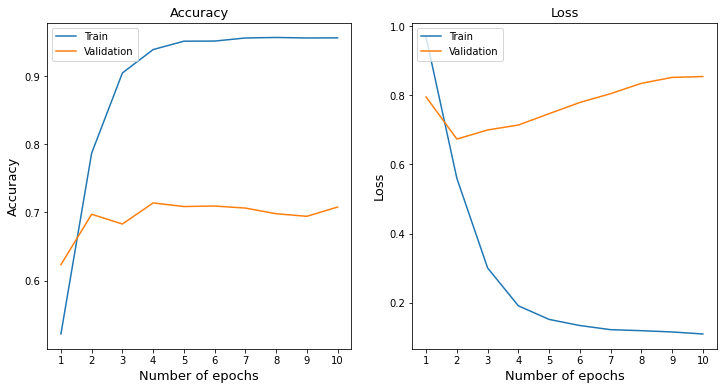

In [172]:
def plot_model(model):
    
    num_epochs = len(model.history.history['accuracy'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.plot(model.history.history['accuracy'])
    ax1.plot(model.history.history['val_accuracy'])
    ax1.set_title("Accuracy", fontsize=13)
    ax1.set_ylabel('Accuracy', fontsize=13)
    ax1.set_xlabel('Number of epochs', fontsize=13)
    ax1.set_xticks(range(0, num_epochs), range(1, num_epochs + 1))
    ax1.legend(['Train', 'Validation'], loc='upper left')
    
    ax2.plot(model.history.history['loss'])
    ax2.plot(model.history.history['val_loss'])
    ax2.set_title("Loss", fontsize=13)
    ax2.set_ylabel('Loss', fontsize=13)
    ax2.set_xlabel('Number of epochs', fontsize=13)
    ax2.set_xticks(range(0, num_epochs), range(1, num_epochs + 1))
    ax2.legend(['Train', 'Validation'], loc='upper left')

    return fig

a = plot_model(model)

# a.savefig(plots_dir / model['Name'])

In [179]:


model = Sequential()
model.add(layers.Embedding(vocab_size, embed_dim, input_length=max_seq_length))
model.add(layers.LSTM(256))

model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
model.fit(padded, labels, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 500, 30)           1122990   
                                                                 
 lstm_10 (LSTM)              (None, 256)               293888    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 512)               131584    
                                                     

KeyboardInterrupt: 

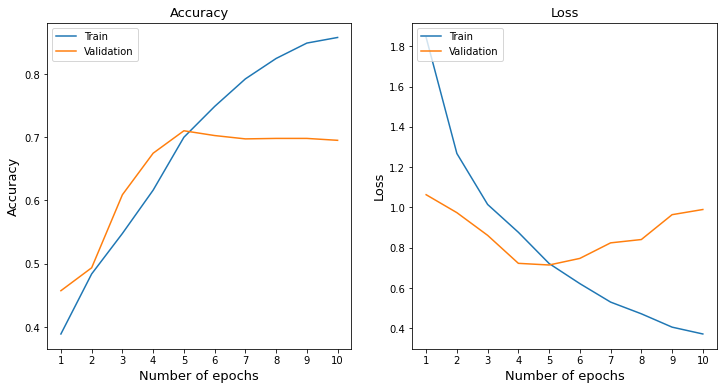

In [181]:
def plot_model(model):
    
    num_epochs = len(model.history.history['accuracy'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.plot(model.history.history['accuracy'])
    ax1.plot(model.history.history['val_accuracy'])
    ax1.set_title("Accuracy", fontsize=13)
    ax1.set_ylabel('Accuracy', fontsize=13)
    ax1.set_xlabel('Number of epochs', fontsize=13)
    ax1.set_xticks(range(0, num_epochs), range(1, num_epochs + 1))
    ax1.legend(['Train', 'Validation'], loc='upper left')
    
    ax2.plot(model.history.history['loss'])
    ax2.plot(model.history.history['val_loss'])
    ax2.set_title("Loss", fontsize=13)
    ax2.set_ylabel('Loss', fontsize=13)
    ax2.set_xlabel('Number of epochs', fontsize=13)
    ax2.set_xticks(range(0, num_epochs), range(1, num_epochs + 1))
    ax2.legend(['Train', 'Validation'], loc='upper left')

    return fig

a = plot_model(model)

# a.savefig(plots_dir / model['Name'])

In [209]:
def fit_model(model, X_train, y_train, batch_size, num_epochs, val):
    model.fit(X_train,
              y_train,
              batch_size,
              epochs=num_epochs,
              validation_split=val)
    
def create_json(model, training_time):
    
    today = date.today()
    now = datetime.now().time()
    
    model_json = {
        "Date": today.strftime("%d/%m/%Y"),
        "Time": now.strftime("%H:%M:%S"),
        "Name": model.name,
        "History": model.history.history,
        "Model": model.to_json(),
        "Vocab size": vocab_size,
        "Embedding size": embedding_size,
        "Max words": max_words,
        "Epochs": num_epochs,
        "Validation split:": val,
        "Training time": training_time
    }
    return model_json

def plot_model(model):
    
    num_epochs = len(model.history.history['accuracy'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4),
                                  constrained_layout=True)    
    ax1.plot(model.history.history['accuracy'])
    ax1.plot(model.history.history['val_accuracy'])
    ax1.set_title("Accuracy", fontsize=13)
    ax1.set_ylabel('Accuracy', fontsize=13)
    ax1.set_xlabel('Number of epochs', fontsize=13)
    ax1.set_xticks(range(0, num_epochs), range(1, num_epochs + 1))
    ax1.legend(['Train', 'Validation'], loc='upper left')
    
    ax2.plot(model.history.history['loss'])
    ax2.plot(model.history.history['val_loss'])
    ax2.set_title("Loss", fontsize=13)
    ax2.set_ylabel('Loss', fontsize=13)
    ax2.set_xlabel('Number of epochs', fontsize=13)
    ax2.set_xticks(range(0, num_epochs), range(1, num_epochs + 1))
    ax2.legend(['Train', 'Validation'], loc='upper left')

    return fig
    
def train_and_save(X_train, y_train, model, batch_size, num_epochs, val):
    
    start = time()
    fit_model(model, X_train, y_train, batch_size, num_epochs, val)
    training_time = time()-start
    
    model_json = create_json(model, training_time)

    plots = plot_model(model)

    plots.savefig(plots_dir / model_json['Name'])

    with open(models_dir / (model_json["Name"] + '.json'), 'w') as json_file:
        json.dump(model_json, json_file)

## Base Model CNN

Training base models using CNN units in the range of 64, 128, 256, 512, 1024, 2048

[64, 128, 256, 512, 1024, 2048]
Epoch 1/10
166/166 [==============================] - 3s 18ms/step - loss: 0.9718 - accuracy: 0.5156 - val_loss: 0.8766 - val_accuracy: 0.5540
Epoch 2/10
166/166 [==============================] - 3s 18ms/step - loss: 0.7405 - accuracy: 0.6877 - val_loss: 0.7339 - val_accuracy: 0.6445
Epoch 3/10
166/166 [==============================] - 3s 18ms/step - loss: 0.5390 - accuracy: 0.7920 - val_loss: 0.6730 - val_accuracy: 0.7011
Epoch 4/10
166/166 [==============================] - 3s 17ms/step - loss: 0.3803 - accuracy: 0.8622 - val_loss: 0.6770 - val_accuracy: 0.7125
Epoch 5/10
166/166 [==============================] - 3s 17ms/step - loss: 0.2729 - accuracy: 0.9030 - val_loss: 0.7098 - val_accuracy: 0.7132
Epoch 6/10
166/166 [==============================] - 3s 18ms/step - loss: 0.2088 - accuracy: 0.9219 - val_loss: 0.7564 - val_accuracy: 0.7102
Epoch 7/10
166/166 [==============================] - 3s 18ms/step - loss: 0.1685 - accuracy: 0.9328 - val_los

Epoch 8/10
166/166 [==============================] - 45s 272ms/step - loss: 0.1307 - accuracy: 0.9415 - val_loss: 1.0492 - val_accuracy: 0.6966
Epoch 9/10
166/166 [==============================] - 44s 266ms/step - loss: 0.1303 - accuracy: 0.9451 - val_loss: 1.1402 - val_accuracy: 0.6747
Epoch 10/10
166/166 [==============================] - 44s 266ms/step - loss: 0.1092 - accuracy: 0.9513 - val_loss: 1.1676 - val_accuracy: 0.6868


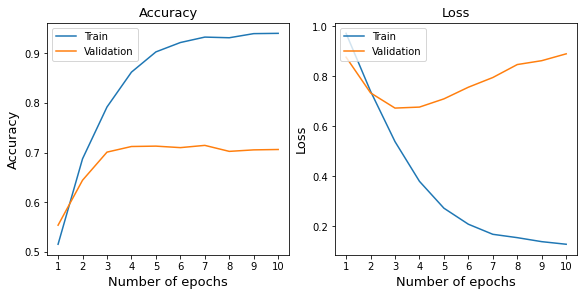

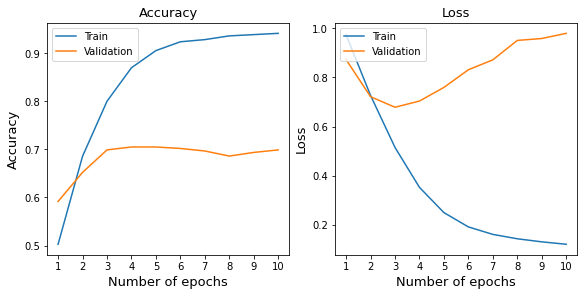

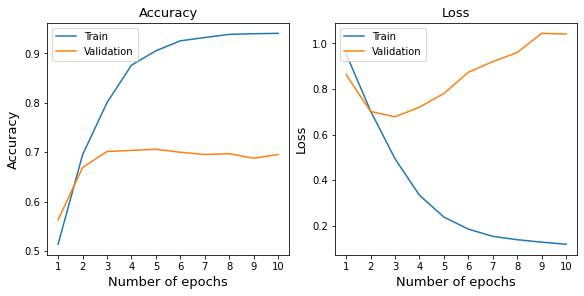

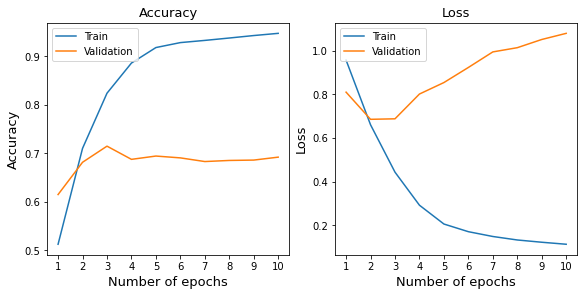

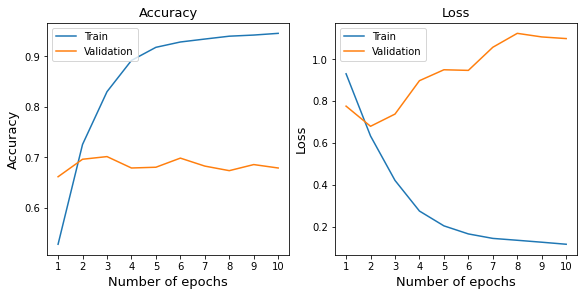

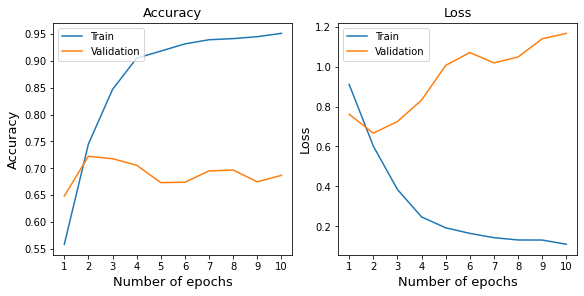

In [211]:
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 30
max_words = 500
cnn_units = [64*2**i for i in range(0,6)]
num_epochs = 10
val = 0.2

print(cnn_units)

for i in cnn_units:
    
    name = 'base_cnn' + f'_{i}'
    
    model = Sequential(name=name)
    model.add(layers.Embedding(vocab_size, embedding_size, input_length=max_seq_length))
    model.add(layers.Conv1D(i, 3, padding='valid', activation='relu', strides=1))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    
    train_and_save(padded, labels, model, 32, num_epochs, val)

# Deep CNNs

### 2-layer CNN

Epoch 1/10
166/166 [==============================] - 12s 72ms/step - loss: 1.5644 - accuracy: 0.4754 - val_loss: 1.0189 - val_accuracy: 0.4574
Epoch 2/10
166/166 [==============================] - 11s 67ms/step - loss: 0.9287 - accuracy: 0.6603 - val_loss: 1.0533 - val_accuracy: 0.4604
Epoch 3/10
166/166 [==============================] - 11s 65ms/step - loss: 0.6623 - accuracy: 0.7647 - val_loss: 0.9752 - val_accuracy: 0.5170
Epoch 4/10
166/166 [==============================] - 11s 65ms/step - loss: 0.5233 - accuracy: 0.8147 - val_loss: 0.8540 - val_accuracy: 0.6475
Epoch 5/10
166/166 [==============================] - 11s 66ms/step - loss: 0.4852 - accuracy: 0.8373 - val_loss: 0.8561 - val_accuracy: 0.6913
Epoch 6/10
166/166 [==============================] - 11s 65ms/step - loss: 0.4189 - accuracy: 0.8620 - val_loss: 0.9125 - val_accuracy: 0.6853
Epoch 7/10
166/166 [==============================] - 11s 66ms/step - loss: 0.3584 - accuracy: 0.8802 - val_loss: 0.9392 - val_accuracy:

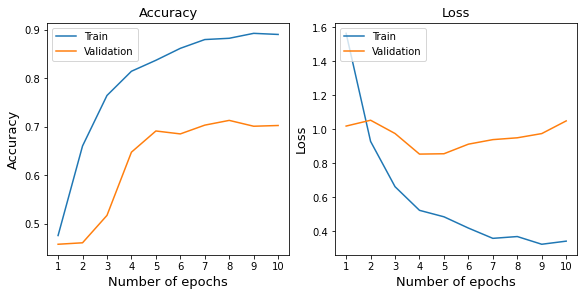

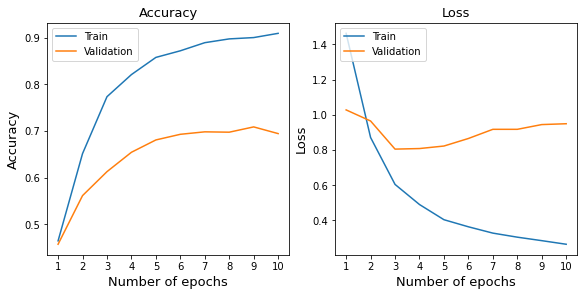

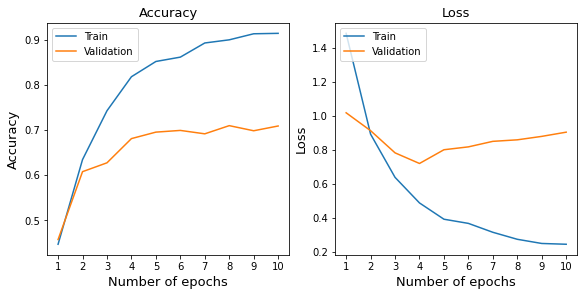

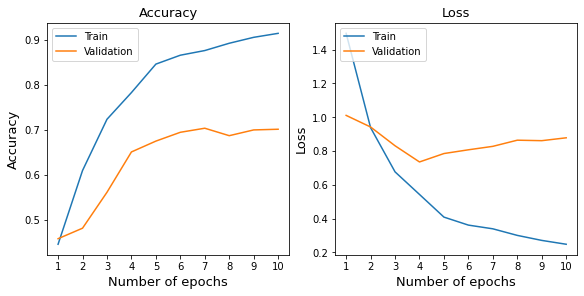

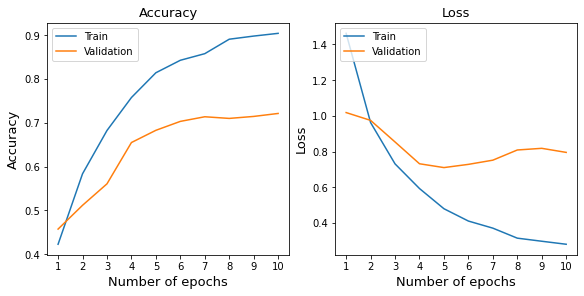

In [217]:
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 30
max_words = 500
cnn_units = [64*2**i for i in range(0,6)]
num_epochs = 10
val = 0.2

for i in range(0, 5):
    name = name = 'two_layer_cnn' + f'_{i+1}'
    model = Sequential(name=name)
    model.add(layers.Embedding(vocab_size, embedding_size, input_length=max_seq_length))
    model.add(layers.Conv1D(512, 3, padding='valid', activation='relu', strides=1))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2048 / 2**i, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    train_and_save(padded, labels, model, 32, num_epochs, val)

### 3-layer CNN

Epoch 1/10
166/166 [==============================] - 15s 89ms/step - loss: 1.7770 - accuracy: 0.4312 - val_loss: 1.0193 - val_accuracy: 0.4574
Epoch 2/10
166/166 [==============================] - 15s 90ms/step - loss: 1.0931 - accuracy: 0.5835 - val_loss: 1.0044 - val_accuracy: 0.4928
Epoch 3/10
166/166 [==============================] - 15s 89ms/step - loss: 0.7985 - accuracy: 0.6947 - val_loss: 0.9170 - val_accuracy: 0.5781
Epoch 4/10
166/166 [==============================] - 15s 88ms/step - loss: 0.6296 - accuracy: 0.7641 - val_loss: 0.7987 - val_accuracy: 0.6453
Epoch 5/10
166/166 [==============================] - 15s 89ms/step - loss: 0.5552 - accuracy: 0.8024 - val_loss: 0.8682 - val_accuracy: 0.6853
Epoch 6/10
166/166 [==============================] - 15s 91ms/step - loss: 0.4524 - accuracy: 0.8398 - val_loss: 0.8925 - val_accuracy: 0.6800
Epoch 7/10
166/166 [==============================] - 15s 92ms/step - loss: 0.4127 - accuracy: 0.8560 - val_loss: 0.9708 - val_accuracy:

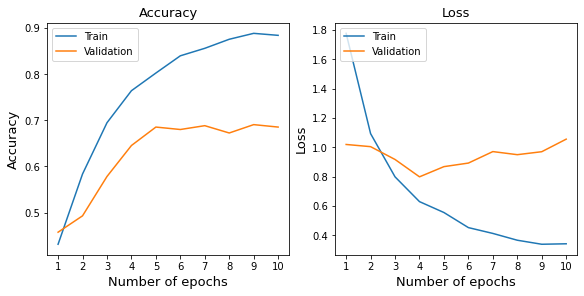

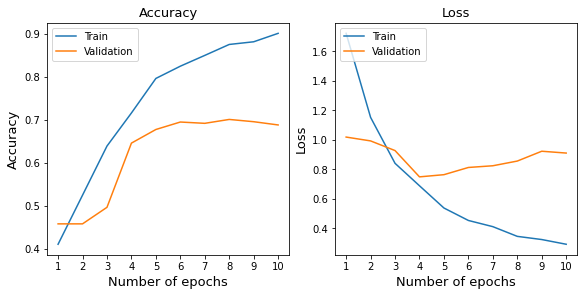

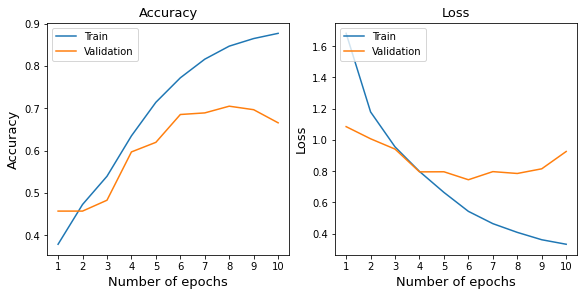

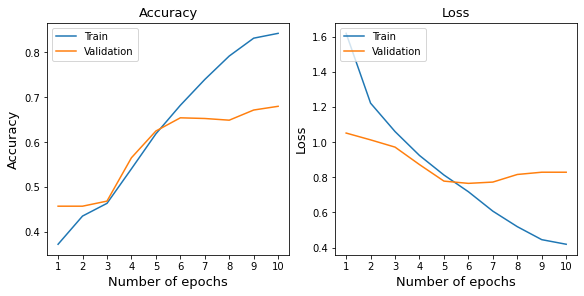

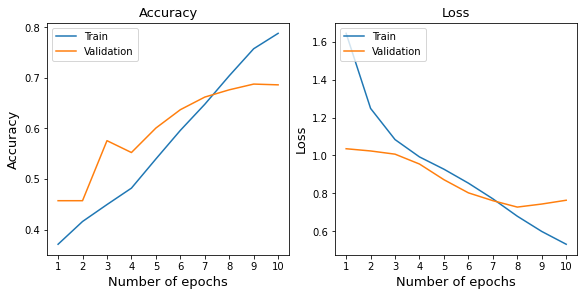

In [219]:
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 30
max_words = 500
cnn_units = [64*2**i for i in range(0,6)]
num_epochs = 10
val = 0.2

for i in range(0, 5):
    name = 'three_layer_cnn' + f'_{i+1}'

    model = Sequential(name=name)
    model.add(layers.Embedding(vocab_size, embedding_size, input_length=max_seq_length))
    model.add(layers.Conv1D(512, 3, padding='valid', activation='relu', strides=1))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2048 / 2**i, activation='relu'))    
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2048 / 2**i+1, activation='relu'))    
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    train_and_save(padded, labels, model, 32, num_epochs, val)

# Training with pretrained embeddings

### rusvectores

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 300
max_words = 500
cnn_units = [64*2**i for i in range(0,6)]
num_epochs = 10
val = 0.2

path_to_model_file = "rusvectores/model.txt"

embeddings_index = {}
with open(path_to_model_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word.split('_')[0]] = coefs

print("Found %s word vectors." % len(embeddings_index))

#create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape


for i in cnn_units:
    name= 'rusvectores_embedding' + f'_{i}'

    model = Sequential(name=name)
    model.add(layers.Embedding(vocab_size, embedding_size,
                               weights=[embedding_matrix],
                               input_length=max_seq_length,
                               trainable=False))
    model.add(layers.Conv1D(512, 3, padding='valid', activation='relu', strides=1))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())

    train_and_save(padded, labels, model, 32, num_epochs, val)

Found 215876 word vectors.
Model: "rusvectores_embedding_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_71 (Embedding)    (None, 500, 300)          11229900  
                                                                 
 conv1d_46 (Conv1D)          (None, 498, 512)          461312    
                                                                 
 global_max_pooling1d_44 (Gl  (None, 512)              0         
 obalMaxPooling1D)                                               
                                                                 
 batch_normalization_40 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_64 (Dropout)        (None, 512)               0         
                                                                 
 dense_85 (Dens

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 300
max_words = 500
cnn_units = [64*2**i for i in range(0,6)]
num_epochs = 10
val = 0.2

path_to_model_file = "rusvectores/model.txt"

embeddings_index = {}
with open(path_to_model_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word.split('_')[0]] = coefs

print("Found %s word vectors." % len(embeddings_index))

#create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape


for i in cnn_units:
    name= 'rusvectores_compare' + f'_{i}'

    model = Sequential(name=name)
    model.add(layers.Embedding(vocab_size, embedding_size,,
                               input_length=max_seq_length))
    model.add(layers.Conv1D(512, 3, padding='valid', activation='relu', strides=1))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())

    train_and_save(padded, labels, model, 32, num_epochs, val)